# Code Description

Code Steps:
    
1. Select variables - This is not part of the code, but rather a first step choice that needs to be made before any clustering may be performed.  For comparison to Koppen-Geiger model, choose precipitation and temperature.  A choice of wavelets will need to be made as well. Any will work, but experience has shown Haar for space and db2 for time work great.
    
2. Preprocess data - Wavelets perform poorly with nan values.  Adjust nan’s for smoother results.

        a. prep_data - Computes a horizontal and vertical interpolation of nan values.  Also computes the average non-nan value.  A linear combination of these values is used to replace the nan values.
    
3. DWT functions - You may want to compute various levels of the DWT at different values for space and time. 

        a. wavelet_levels - The following code computes the DWT in space-time.    The data for LOCA has space as [1,2], so program is currently hard coded for this.
        
4. Filtering functions - We don’t want to cluster where nan values are, even after preprocessing the data.  The functions here are tools to be used throughout the code.

        a. build_masks - Given a data cube, construct all the different nan_masks needed for clustering.  These include a nan-cube, a nan-slice, and an eroded nan_slice (remove boundary of nans). Clustering is performed on complement of nan_er_cube.
        
        b. filter_out_nan - This function filters out nan values from a matrix nxm, and saves the index for threading back together.
        
        c. filter_in_nan - The inverse function of filter_out_nan - used to put nan values back into set after clustering.
        
5. K-means - Here we compute the k-means clustering on the DWT coefficients of interest. 

        a. filter_kmeans - This function combines the dwt's to result in dwt of data + epsilon boundary.  We then cluster on the non-nan values of this result.  The final classes are laced with the nan-values.
            i. Various tests with silhouette and Calinski-Harabaz scores suggests setting k=3 for precipitation data and K=4 for temperature data

6. Map clustering on DWT to initial data - Having clustered on approximation coefficients of DWT, we now map this information back to the initial data points. This is trivial in the case of the Haar wavelet (just double spatial coordinates for each level).  However, for wavelets with window lengths larger than 2, choices need to be made.  Many parts of this code are used to build the filter matrix, a matrix used to inflate data from the DWT back to initial data size.

        a. dwt_length - Record the lengths of the data at each wavelet transform.  It records how the length of lat, lon, or time will change with each wavelet transform. This function is run outside map_back_classes.
        
        b. middle_match  - build the middle part of the filter matrix
        
        c. top_match - build the top part of the filter matrix
        
        d. bot_match - build the bottom part of the filter matrix
        
        e. filter_matrix - Function used to build filter matrix for mapping classes back one level
        
        f. map_back_index - function used to discover classes at one stage higher resolution.  This is done by first building the filter matrix, and choosing the index that has the largest value in magnitude.
        
        g. map_back_classes - Function used to map the MR clusters back to the initial data points
        
7. Combine Classes - Having clustered on each variable separately (e.g. Prec, Tmin and Tmax), we now combine the classes by looking at their overlap. 
    
        a. produce_labels - Create a lex index for each possible clustering array (skipping nan)
        
        b. thresh_lex - Delete classes that small below a set threshold for size.  Then, relabel with smallest possible counting set.  Nan class set to -1, and removed class set to 0
        
        c. combine_classes - takes separate clusterings and converts them into a single clustering.
        
8. Main Function - Here we put everything together to run the clustering algorithm

        a. MR_sets - Compute all levels of the DWT of interest and clusters on chosen levels. This is done for a single variable (e.g. Precipitation). For a single clustering, specify level_time_lo = level_time_hi and level_space_lo = level_space_hi.
        
        b. clustering - Run the complete clustering algorithm on the LOCA data set using Prec, Tmax and Tmin.  Currently hard coded to run for 20 years (240 time slices).


In [89]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage
from sklearn.metrics import silhouette_score, calinski_harabaz_score
import matplotlib.colors as color

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [3]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [4]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/Users/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc', autoclose=True)
end = time.time()
print(end - start)

11.6796729565


# Define functions in package:

## Preprocess data:

In [52]:
def prep_data(data, variable, factor_h, factor_v, factor_a):
    '''
    Computes a horizontal and vertical interpolation of nan values.  Also computes the average non-nan value.  A linear combination of these values is used to replace the nan values.

    Inputs:
    data = input xarray data set
    variable = variable of interest
    factor_h = coefficent in linear combination for x-direction
    factor_v = coefficent in linear combination for y-direction
    factor_a = coefficent in linear combination for averages
    
    Returns:
    final = the preprocessed data
    '''
    
    #Horizontal interpolation
    start = time.time()
    data_h = data[variable].to_dataframe()
    data_h = data_h.interpolate(limit_direction = 'both')
    data_h = data_h.to_xarray()
    data_h = data_h[variable].data
    print("Horz. Time: " + str(time.time() - start))
    
    #Vertical interpolation
    start = time.time()
    data_v = data[variable].transpose('time','lon','lat')
    data_v = data_v.to_dataframe()
    data_v = data_v.interpolate(limit_direction = 'both')
    data_v = data_v.to_xarray()
    data_v = data_v.transpose('time','lat','lon')
    data_v = data_v[variable].data
    print("Vert. Time: " + str(time.time() - start))
    
    
    #Average value
    #Create small noise.  This is to ensure that areas where the variable is zero do not get set to mean.
    noise = np.random.rand(dst.time.size, dst.lat.size, dst.lon.size)
    noise = noise/10000
    
    start = time.time()    
    mean = np.array(data[variable].mean())
    #Add the noise once mean is found
    data[variable] = data[variable]+noise
    
    data_a = da.nan_to_num(data[variable].data)
    data_a[data_a==0] = mean
    data_a = np.array(data_a)
    print("Ave. Time: " + str(time.time() - start))
    #Linear combo
    final = (factor_h*data_h + factor_v*data_v + factor_a*data_a)/(factor_h + factor_v + factor_a)
    
    return final

## DWT Functions

In [37]:
def wavelet_levels(data_set, level_time, level_space, wavelet_time, wavelet_space):
    '''
    The following code computes the DWT in space-time.    The data for LOCA has space as [1,2], so program is currently hard coded for this.
    
    Inputs: 
    data_set = numpy or dask array of nan_filtered variable
    level_time = number of DWT to take in time
    level_space = number of DWT to take in space
    wavelet_time = wavelet to use for time
    wavelet_space = wavelet to use for time
    
    Returns:
    wp = the DWT.
    
    '''
    
    wp = pywt.wavedecn(data=data_set, wavelet = wavelet_space, level = level_space, axes = [1,2])
    wp = pywt.wavedecn(data=wp[0], wavelet = wavelet_time, level = level_time, axes = [0])
    
    return wp

## Filtering Functions

In [36]:
def build_masks(data, iterations=2):
    '''
    Given a data cube, construct all the different nan_masks needed for clustering. These include a nan-cube, a nan-slice, and an eroded nan_slice (remove boundary of nans).  Clustering is performed on complement of nan_er_cube.
    
    Inputs:
    data = Any numpy tensor of the data (e.g. ds.Prec.data).  Only used to match size
    iterations = int telling how many layers of the nan_slice to erode
    
    Returns:
    nan_mask_cube = tensor of nan_data
    nan_mask_slice = one time slice of the nan_mask
    nan_mask_er_cube = each time slice is has iterations worth of nan values eroded.  These are stacked, and then the complament is taken to form the nan_mask_er_cube (i.e. 0's at nan values, nan at real values)
    '''
    #First, get cube of nan_mask
    nan_mask_cube = np.isnan(data)
    nan_mask_cube = np.array(nan_mask_cube)
    nan_mask_cube = nan_mask_cube*np.array(data)
    
    #Get a single slice of nan_mask
    nan_mask_slice = nan_mask_cube[0]
    
    #Erode nan values for difference in clustering
    nan_mask_er = scipy.ndimage.morphology.binary_erosion(nan_mask_slice, iterations= iterations).astype(nan_mask_slice.dtype)
    
    #Build cube of erroded nan_mask:
    nan_mask_er_cube = np.tile(nan_mask_er, (data.shape[0],1,1))
    nan_mask_er_cube[nan_mask_er_cube ==1] = np.nan
    
    return nan_mask_cube, nan_mask_slice, nan_mask_er_cube

In [34]:
def filter_out_nan(shaped):
    '''
    This function filters out nan values from a matrix nxm, and saves the index for threading back together
    
    Inputs:
    shaped = a numpy array of with shape (number of data points)x(dimension of data points).  This is the format for clustering.
    
    Returns:
    data = the shaped list with all nan values removed
    index = the location of the non-nan values in the shaped list
    index_nan = the location of the nan values in the shaped list
    '''
    
    
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [35]:
def filter_in_nan(classes, index, index_nan):
    '''
    The inverse function of filter_out_nan - used to put nan values back into set after clustering
    
    Inputs:
    classes = classes from clustering.  This is a vector of length (number of non-nan data points)
    index = the location of the non-nan values in the shaped list
    index_nan = the location of the nan values in the shaped list
    
    Returns:
    classes = classes from clustering with nan's filtered into slots where nans should appear
    '''
    
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

## K-means

In [38]:
def filter_kmeans(dwt_data, dwt_nan, n_clusters):
    '''
    This function combines the dwt's to result in dwt of data + epsilon boundary.  We then cluster on the non-nan values of this result.  The final classes are laced with the nan-values.
    
    
    Inputs:
    dwt_data = the approximation coefficients from DWT of a variable (this is the w[0] output from wavelet_levels)
    dwt_nan = the dwt of the nan_mask_cube
    n_cluster = number of clusters
    
    Returns:
    classes = the clusters on the approximation coefficients
    '''
    
    #Combine the DWT of each:
    data = dwt_data[0] + dwt_nan[0]  #the zero is to select the approximation coeff.
    
    #Reshape the data:
    shaped = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
    shaped = shaped.T
    
    #Filter out nan values
    start = time.time()
    data_t, index_t, index_nan_t = filter_out_nan(shaped)
    end = time.time()
    print("Filter out: " + str(end - start))
    
    #K-means the result
    start=time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_t)
    classes = kmeans.labels_
    end = time.time()
    print("Clustering: " + str(end - start))
    
    #Filter back in the nan values
    classes = filter_in_nan(classes, index_t, index_nan_t)
    
    #Reshape
    classes = np.reshape(classes, (data.shape[1],data.shape[2]))
    
    return classes

## Map clustering on DWT to initial data

In [40]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [41]:
def dwt_length(data, wavelet):
    '''
    Record the lengths of the data at each wavelet transform.  It records how the length of lat, lon, or time will change with each wavelet transform. This function is run outside map_back_classes.
    
    Inputs:
    data = a chosen coordinate (e.g. ds.lat)
    wavelet = chosen wavelet
    
    Returns:
    dwt_lengths = string of lengths of the 
    '''
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wavelet).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wavelet).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [42]:
def middle_match(data_len,wavelet):
    '''
    Build the middle part of the filter matrix
    
    Inputs:
    data_len = a length of a data coordinate
    wavelet = chosen wavelet
    
    Returns:
    I_m = the middle part of the filter matrix
    '''
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((float(data_len)-w_len)/2))
    
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [43]:
def top_match(data_len, wavelet):
    '''
    Build the top part of the filter matrix
    
    
    Inputs:
    data_len = a length of a data coordinate
    wavelet = chosen wavelet
    
    Returns:
    I_t = the top part of the filter matrix
    '''    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [44]:
def bot_match(data_len, wavelet):
    '''
    Build the bottom part of the filter matrix
    
    Inputs:
    data_len = a length of a data coordinate
    wavelet = chosen wavelet
    
    Returns:
    I_b = the bottom part of the filter matrix
    '''   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    
    
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [45]:
def filter_matrix(data_len, wavelet):
    '''
    Function used to build filter matrix for mapping classes back one level
    
    Inputs:
    data_len = a length of a data coordinate
    wavelet = chosen wavelet
    
    Returns:
    I = the complete filter matrix
    '''
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [46]:
def map_back_index(wavelet, dwt_lengths, max_level):
    '''
    Function used to discover classes at one stage higher resolution.  This is done by first building the filter matrix, and choosing the index that has the largest value in magnitude. 
    
    Inputs:
    wavelet = chosen wavelet
    dwt_lengths = lengths from the dwt transform (output of dwt_length)
    max_level = maximum level allowed by dwt
    
    Returns:
    index_up = location for mapping back up one level of DWT along chosen coordinate
    '''
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

In [47]:
def map_back_classes(MR_clusters, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi):
    """
    Function used to map the MR clusters back to the initial data points
    
    Inputs: 
    MR_clusters = clusters from clustering algorithm
    index_up_lat = output of map_back_index for lat
    index_up_lon = output of map_back_index for lon
    level_time_lo = lowest level of DWT in time
    level_time_hi = highest level of DWT in time
    level_space_lo = lowest level of DWT in space
    level_space_hi = highest level of DWT in space
    
    Returns:
    final_class = The classes from clustering mapped back onto the initial data points
    """
    final_class = {}
    for i in range(level_space_lo, level_space_hi+1):
        for j in range(level_time_lo, level_time_hi+1):
            temp = MR_clusters[i,j]
            for k in range(1,i+1):
                temp = temp[index_up_lat[i-k]][:,index_up_lon[i-k]]
            final_class[i,j] = temp
    
    return final_class

## Combine Classes

In [48]:
def produce_labels(stacked):
    '''
    Create a lex index for each possible clustering array (skipping nan)
    
    Inputs:
    stacked = data clusters stacked ontop of eachother.  This forms a (number of clusters)x(number of points) array.  Important that it has no nan values.
    
    Returns:
    labels = an index used for classes
    '''
    index = 0
    labels = {}
    for col in range(stacked.shape[1]):
            labels[stacked[:,col].tobytes()] = index
            index = index+ 1
                
    return labels

In [49]:
def thresh_lex(lexlabels, nan_mask_slice, fraction=0.002):
    """
    Delete classes that small below a set threshold for size.  Then, relabel with smallest possible counting set.  Nan class set to -1, and removed class set to 0
    
    Inputs:
    lexlabels = a labeling of the k-values at each point into a lex ordering. This is produced inside combine_classes function.
    nan_mask_slice = nan mask for a single time slice
    fraction = fraction used to threshold:  If (number of points in class k)/(total number of points) < fraction, set to undefined. 
    
    Outputs:
    lexlabels_thresh = the thresholded classes
    
    """
    lexlabels_thresh = lexlabels
    #Replace the numbers that appear from lex labels with smallest possible counting set
    count = 0
    for number in np.unique(lexlabels_thresh):
        lexlabels_thresh[lexlabels_thresh==number] = count
        count = count+1
        
    #Set delete class if too small based of fraction:
    thresh = np.count_nonzero(~np.isnan(nan_mask_slice))*fraction
    
    number_labels = np.unique(lexlabels_thresh).size
    
    #We will delete class corresponding to the nan, and put all the small classes together.
    #First, remove the class where nans are:
    #Shift all the index up by 2 to make room:
    lexlabels_thresh = lexlabels_thresh +2
    
    #Find out where the nan values are, and set them to zero
    masking = np.nan_to_num(nan_mask_slice+1)
    lexlabels_thresh = masking*lexlabels_thresh
    
    #Remove classes with a small number of points to unclassified.  These are set to class 1
    for i in range(number_labels):
        if np.count_nonzero(lexlabels_thresh==i) <thresh:
            ind = np.argwhere(lexlabels_thresh==i)
            for [a,b] in ind:
                lexlabels_thresh[a,b] = 1    
    
    #Recount again with removed labels.  This sets the nan class to -1, and removed class to 0:
    count = -1
    for number in np.unique(lexlabels_thresh):
        lexlabels_thresh[lexlabels_thresh==number] = count
        count = count+1
        
    #number_labels_thresh = np.max(lexlabels_thresh)
    #number_labels_thresh
    
    #Add nan mask
    #lexlabels_thresh = lexlabels_thresh + nan_mask_slice
    
    return lexlabels_thresh

In [50]:
def combine_classes(stacked, nan_mask_slice, fraction=0.002):
    '''
    Takes separate clusterings and converts them into a single clustering.
    
    Inputs:
    stacked = data clusters stacked ontop of eachother.  This forms a (number of clusters)x(number of points) array.  Important that it has no nan values.
    nan_mask_slice = nan mask for a single time slice
    fraction = fraction used to threshold:  If (number of points in class k)/(total number of points) < fraction, set to undefined. 
    
    Outputs:
    lexlabels_thresh = the thresholded classes
    '''
    #Produce labels
    labels = produce_labels(stacked)
    
    #Convert the array of k-values at each point into lex labels
    lexlabels = []
    for col in range(stacked.shape[1]):
            lexlabels.append(labels[stacked[:,col].tobytes()])
    
    lexlabels = np.array(lexlabels)
    lexlabels = np.reshape(lexlabels,(ds.lat.size,ds.lon.size))
    
    #Threshold the labels
    lexlabels_thresh = thresh_lex(lexlabels, nan_mask_slice, fraction)
    
    return lexlabels_thresh

# Main Function

In [51]:
def MR_sets(data_set, nan_mask_er_cube, level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_time = 'haar', wavelet_space='haar', n_clusters = 3):
    """
    Compute all levels of the DWT of interest and clusters on chosen levels. This is done for a single variable (e.g. Precipitation). For a single clustering, specify level_time_lo = level_time_hi and level_space_lo = level_space_hi.
    
    Inputs:
    data_set = preprocessed data variable (output of prep_data)
    nan_mask_er_cube = each time slice is has iterations worth of nan values eroded (output of build_masks)
    level_time_lo = lowest level of DWT in time
    level_time_hi = highest level of DWT in time
    level_space_lo = lowest level of DWT in space
    level_space_hi = highest level of DWT in space
    wavelet_time = wavelet to use for time
    wavelet_space = wavelet to use for time
    n_clusters = number of clusters
    
    Returns:
    MR_clusters = the clustering performed at each resolution
    """
    startt=time.time()
    
    print("Level Space: " + str(level_space_lo))
    print("Level Time: " + str(level_time_lo))   
    
    #Initial DWT's
    start = time.time()
    wp = wavelet_levels(data_set, level_time_lo, level_space_lo, wavelet_time, wavelet_space)
    dwt_nan = wavelet_levels(nan_mask_er_cube, level_time_lo, level_space_lo, wavelet_time, wavelet_space)
    end=time.time()
    diff = str(end-start)
    print("DWT: " + diff)
    
    #Find classes (classes shaped with nans added back):
    start=time.time()
    classes = filter_kmeans(wp,dwt_nan, n_clusters)
    end = time.time()
    diff = str(end-start)
    print("Clustering: " + diff)
    
    #Save the cluster
    MR_clusters = {(level_space_lo,level_time_lo): classes}
    
    print("")
    #The time DWT for first spatial level
    
    #Create a temp list to use for time DWTs
    wp_t = list(wp)
    dwt_nan_t = list(dwt_nan)
    for j in range(level_time_lo+1, level_time_hi+1):
        #Time DWT:
        print("Level Space: " + str(level_space_lo))
        print("Level Time: " + str(j)) 
        start = time.time()
        wp_t = wavelet_levels(wp_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
        dwt_nan_t = wavelet_levels(dwt_nan_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space) #Can probably remove this...times don't change
        end=time.time()
        diff = str(end-start)
        print("DWT: " + diff)
            
        #Find classes (classes shaped with nans added back):
        start=time.time()
        classes = filter_kmeans(wp_t,dwt_nan_t, n_clusters)
        end = time.time()
        diff = str(end-start)
        print("Clustering: " + diff)
    
        #Save the cluster
        MR_clusters = {(level_space_lo,level_time_lo): classes}
        
        print("")
    
    
    #Increment the dwt levels and cluster
    for i in range(level_space_lo+1,level_space_hi+1):
        #Space DWT:
        print("Level Space: " + str(i))
        print("Level Time: " + str(level_time_lo)) 
        start = time.time()
        wp = wavelet_levels(wp[0], level_time = 0, level_space = 1, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
        dwt_nan = wavelet_levels(dwt_nan[0], level_time_lo, level_space_lo, wavelet_time, wavelet_space)
        end=time.time()
        diff = str(end-start)
        print("DWT: " + diff)
        
        #Find classes (classes shaped with nans added back):
        start=time.time()
        classes = filter_kmeans(wp,dwt_nan, n_clusters)
        end = time.time()
        diff = str(end-start)
        print("Clustering: " + diff)
    
        #Save the cluster
        MR_clusters = {(level_space_lo,level_time_lo): classes}
        
        print("")
        
        #Create a temp list to use for time DWTs
        wp_t = list(wp)
        dwt_nan_t = list(dwt_nan)
        for j in range(level_time_lo+1, level_time_hi+1):
            #Time DWT:
            print("Level Space: " + str(i))
            print("Level Time: " + str(j)) 
            start = time.time()
            wp_t = wavelet_levels(wp_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
            dwt_nan_t = wavelet_levels(dwt_nan_t[0], level_time = 1, level_space = 0, wavelet_time = wavelet_time, wavelet_space = wavelet_space)
            end=time.time()
            diff = str(end-start)
            print("DWT: " + diff)
            
            #Find classes (classes shaped with nans added back):
            start=time.time()
            classes = filter_kmeans(wp,dwt_nan_t, n_clusters)
            end = time.time()
            diff = str(end-start)
            print("Clustering: " + diff)
            
            print("")
            
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    
    return MR_clusters

In [53]:
def clustering(dst):
    '''
    Run the complete clustering algorithm on the LOCA data set using Prec, Tmax and Tmin.  Currently hard coded to run for 20 years (240 time slices).
    
    Inputs:
    dst = selected time slice of the xarray data set
    
    Returns:
    Prec_classes = clustering on Prec
    Tmax_classes = clustering on Tmax
    Tmin_classes = clustering on Tmin
    lexlabels_thresh = combined clustering
    '''
    #Set up data:
    
    #Prec data interpolated to remove nan
    data_Prec = prep_data(dst,'Prec',1,1,6)
    #Tmax data interpolated to remove nan
    data_Tmax = prep_data(dst,'Tmax',1,1,6)
    #Tmin data interpolated to remove nan
    data_Tmin = prep_data(dst,'Tmin',1,1,6)
    
    #Set up variables to be used
    #Get Nan_mask
    nan_mask_cube, nan_mask_slice, nan_mask_er_cube = build_masks(ds.Prec.data, iterations=4)

    #First, the time information:
    wave_time = 'db2'
    max_level_time = pywt.dwt_max_level(data_len = ds.time.size, filter_len = pywt.Wavelet(wave_time).dec_len) 

    #Next, space information:
    wave_space = 'haar'
    max_level_lat= pywt.dwt_max_level(data_len = ds.lat.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
    max_level_lon= pywt.dwt_max_level(data_len = ds.lon.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
    max_level= min(max_level_lat, max_level_lon, max_level_time)

    #In order to invert the DWT classifier, need lengths for lat, lon, time:

    #dwt_lengths_time = dwt_length(ds.time, wave_time)
    dwt_lengths_lat = dwt_length(ds.lat, wave_space)
    dwt_lengths_lon = dwt_length(ds.lon, wave_space)

    #index_up_time = map_back_index(wave_time,dwt_lengths_time,max_level_time)
    index_up_lat = map_back_index(wave_space,dwt_lengths_lat,max_level_lat)
    index_up_lon = map_back_index(wave_space,dwt_lengths_lon,max_level_lon)

    #Set the bounds for space and time levels of DWT
    level_time_lo=0
    level_time_hi=0
    level_space_lo=1
    level_space_hi=1
    
    #Compute Clusters:
    MR_clusters_Prec = MR_sets(data_Prec, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 3)
    Prec_classes = map_back_classes(MR_clusters_Prec, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    MR_clusters_Tmax = MR_sets(data_Tmax, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 4)
    Tmax_classes = map_back_classes(MR_clusters_Tmax, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    MR_clusters_Tmin = MR_sets(data_Tmin, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 4)
    Tmin_classes = map_back_classes(MR_clusters_Tmin, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    
    #Combine clusters:
    
    stacked = np.stack((Prec_classes[(1,0)], Tmax_classes[(1,0)], Tmin_classes[(1,0)]))
    stacked = stacked.reshape((3,ds.lat.size*ds.lon.size))
    lexlabels_thresh = combine_classes(stacked, nan_mask_slice)
    
    return Prec_classes, Tmax_classes, Tmin_classes, lexlabels_thresh

# Test Algorithm on Data:

In [56]:
#Time to do a single clustering at this resolution
#(48.6665360928 + 51.7778990269 + 14.1644079685 + 49.4582858086 + 50.814977169 + 13.7983682156 +49.2783031464 + 51.7278950214 +12.460185051 + 127.660867929 + 126.88735199 + 126.408263922)/60

In [57]:
#12*44/60

## Compute Series of classes

In [61]:
#Compute the first time slices data

In [62]:
dst = ds.isel(time=slice(0,240))

In [63]:
dst.time

<xarray.DataArray 'time' (time: 240)>
array(['1950-01-16T00:00:00.000000000', '1950-02-14T12:00:00.000000000',
       '1950-03-16T00:00:00.000000000', ..., '1969-10-16T00:00:00.000000000',
       '1969-11-15T12:00:00.000000000', '1969-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16 1950-02-14T12:00:00 1950-03-16 ...
Attributes:
    standard_name:  time
    long_name:      Time axis

In [64]:
Prec_classes, Tmax_classes, Tmin_classes, lexlabels_thresh = clustering(dst)

Horz. Time: 48.4427421093
Vert. Time: 50.4121160507
Ave. Time: 16.7472250462
Horz. Time: 50.0442490578
Vert. Time: 50.4537870884
Ave. Time: 16.3709540367
Horz. Time: 49.4966180325
Vert. Time: 50.5137529373
Ave. Time: 16.134747982
Level Space: 1
Level Time: 0
DWT: 9.19873094559
Filter out: 17.3820140362
Clustering: 80.6071350574
Clustering: 98.3488519192

TOTAL: 107.548293114
Level Space: 1
Level Time: 0
DWT: 9.08097195625
Filter out: 23.0539751053
Clustering: 82.987030983
Clustering: 106.400467157

TOTAL: 115.48273015
Level Space: 1
Level Time: 0
DWT: 9.06535100937
Filter out: 17.959882021
Clustering: 83.4519760609
Clustering: 101.776394844

TOTAL: 110.843252182


In [65]:
np.save('Prec_class_first_0_1_240', Prec_classes)
np.save('Tmax_class_first_0_1_240', Tmax_classes)
np.save('Tmin_class_first_0_1_240', Tmin_classes)
np.save('label_first_0_1_240', lexlabels_thresh)

In [67]:
np.nanmax(lexlabels_thresh)

23.0

In [61]:
#Compute the last time slices data

In [54]:
dst = ds.isel(time=slice(528,768))

In [55]:
dst.time

<xarray.DataArray 'time' (time: 240)>
array(['1994-01-16T00:00:00.000000000', '1994-02-14T12:00:00.000000000',
       '1994-03-16T00:00:00.000000000', ..., '2013-10-16T00:00:00.000000000',
       '2013-11-15T12:00:00.000000000', '2013-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1994-01-16 1994-02-14T12:00:00 1994-03-16 ...
Attributes:
    standard_name:  time
    long_name:      Time axis

In [58]:
Prec_classes, Tmax_classes, Tmin_classes, lexlabels_thresh = clustering(dst)

Horz. Time: 48.4499108791
Vert. Time: 50.4172110558
Ave. Time: 17.3733808994
Horz. Time: 49.2179279327
Vert. Time: 50.6559109688
Ave. Time: 17.3843770027
Horz. Time: 48.6139640808
Vert. Time: 50.5986959934
Ave. Time: 17.3420598507
Level Space: 1
Level Time: 0
DWT: 9.10622191429
Filter out: 17.1671350002
Clustering: 81.3099031448
Clustering: 98.8443570137

TOTAL: 107.951967001
Level Space: 1
Level Time: 0
DWT: 9.09245705605
Filter out: 17.1951889992
Clustering: 82.5782358646
Clustering: 100.142996788

TOTAL: 109.23687911
Level Space: 1
Level Time: 0
DWT: 9.17681884766
Filter out: 17.8112108707
Clustering: 88.0629198551
Clustering: 106.236275911

TOTAL: 115.414634943


In [60]:
np.save('Prec_class_last_0_1_240', Prec_classes)
np.save('Tmax_class_last_0_1_240', Tmax_classes)
np.save('Tmin_class_last_0_1_240', Tmin_classes)
np.save('label_last_0_1_240', lexlabels_thresh)

## Compute each clustering over desired times and spacing:

In [1060]:
#Set of time slices
t_chunk = 12*20
t_delta = 20*12
steps = (768-t_chunk)/(t_delta)

In [ ]:
Prec_classes_all = {}
Tmax_classes_all = {}
Tmin_classes_all = {}
labels_all = {}

for step in range(steps+1):
    dst = ds.isel(time=slice(t_delta*step,t_chunk+t_delta*step))
    
    Prec_classes_all[step], Tmax_classes_all[step], Tmin_classes_all[step], labels_all[step] = clustering(dst)

In [1056]:
Prec_classes_all = {}
Tmax_classes_all = {}
Tmin_classes_all = {}
labels_all = {}

for step in range(steps+1):
    dst = ds.isel(time=slice(t_delta*step,t_chunk+t_delta*step))
    #dst = ds.isel(time=slice(528,768))
    
    #Set up data:
    
    #Prec data interpolated to remove nan
    data_Prec = prep_data(dst,'Prec',1,1,6)
    #Tmax data interpolated to remove nan
    data_Tmax = prep_data(dst,'Tmax',1,1,6)
    #Tmin data interpolated to remove nan
    data_Tmin = prep_data(dst,'Tmin',1,1,6)
    
    #Set up variables to be used
    #Get Nan_mask
    nan_mask_cube, nan_mask_slice, nan_mask_er_cube = build_masks(ds2.Prec.data, iterations=4)

    #First, the time information:
    wave_time = 'db2'
    max_level_time = pywt.dwt_max_level(data_len = ds2.time.size, filter_len = pywt.Wavelet(wave_time).dec_len) 

    #Next, space information:
    wave_space = 'haar'
    max_level_lat= pywt.dwt_max_level(data_len = ds2.lat.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
    max_level_lon= pywt.dwt_max_level(data_len = ds2.lon.size, filter_len = pywt.Wavelet(wave_space).dec_len) 
    max_level= min(max_level_lat, max_level_lon, max_level_time)

    #In order to invert the DWT classifier, need lengths for lat, lon, time:

    #dwt_lengths_time = dwt_length(ds2.time, wave_time)
    dwt_lengths_lat = dwt_length(ds2.lat, wave_space)
    dwt_lengths_lon = dwt_length(ds2.lon, wave_space)

    #index_up_time = map_back_index(wave_time,dwt_lengths_time,max_level_time)
    index_up_lat = map_back_index(wave_space,dwt_lengths_lat,max_level_lat)
    index_up_lon = map_back_index(wave_space,dwt_lengths_lon,max_level_lon)

    #Set the bounds for space and time levels of DWT
    level_time_lo=0
    level_time_hi=0
    level_space_lo=1
    level_space_hi=1
    
    #Compute Clusters:
    MR_clusters_Prec = MR_sets(data_Prec, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 3)
    Prec_classes = map_back_classes(MR_clusters_Prec, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    MR_clusters_Tmax = MR_sets(data_Tmax, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 4)
    Tmax_classes = map_back_classes(MR_clusters_Tmax, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    MR_clusters_Tmin = MR_sets(data_Tmin, nan_mask_er_cube[0:240], level_time_lo, level_time_hi, level_space_lo, level_space_hi, wavelet_space = wave_space, wavelet_time = wave_time, n_clusters = 4)
    Tmin_classes = map_back_classes(MR_clusters_Tmin, index_up_lat, index_up_lon, level_time_lo, level_time_hi, level_space_lo, level_space_hi)
    
    Prec_classes_all[step] = Prec_classes
    Tmax_classes_all[step] = Tmax_classes
    Tmin_classes_all[step] = Tmin_classes
    
    #Combine clusters:
    
    stacked = np.stack((Prec_classes[(1,0)], Tmax_classes[(1,0)], Tmin_classes[(1,0)]))
    stacked = stacked.reshape((3,ds2.lat.size*ds2.lon.size))
    lexlabels_thresh = combine_classes(stacked, nan_mask_slice)
    
    labels_all[step] = lexlabels_thresh

KeyboardInterrupt: 

# Plots for talk

In [965]:
data_Prec.shape

(480, 614, 928)

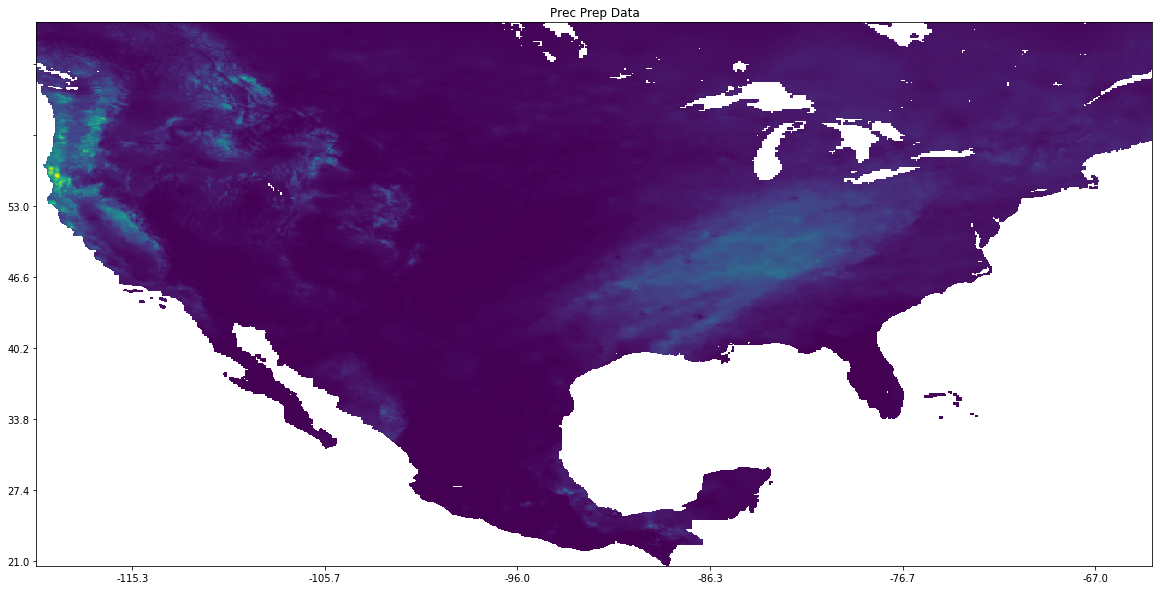

In [998]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)

p0 = ax.pcolormesh(ds.lon, ds.lat, ds.Prec.isel(time=0))
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title("Prec Prep Data")

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

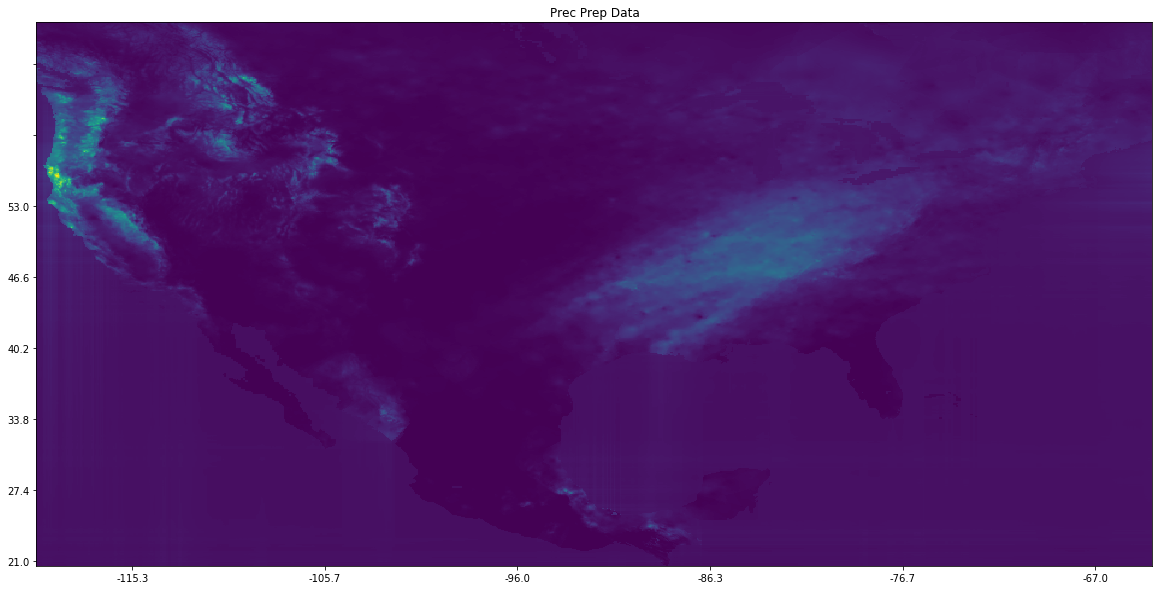

In [999]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)

p0 = ax.pcolormesh(ds.lon, ds.lat, data_Prec[0])
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title("Prec Prep Data")

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

In [1014]:
wp = pywt.wavedecn(data=data_Prec, wavelet = 'haar', level = 2, axes = [1,2])

In [1015]:
wp[0][0].shape

(154, 232)

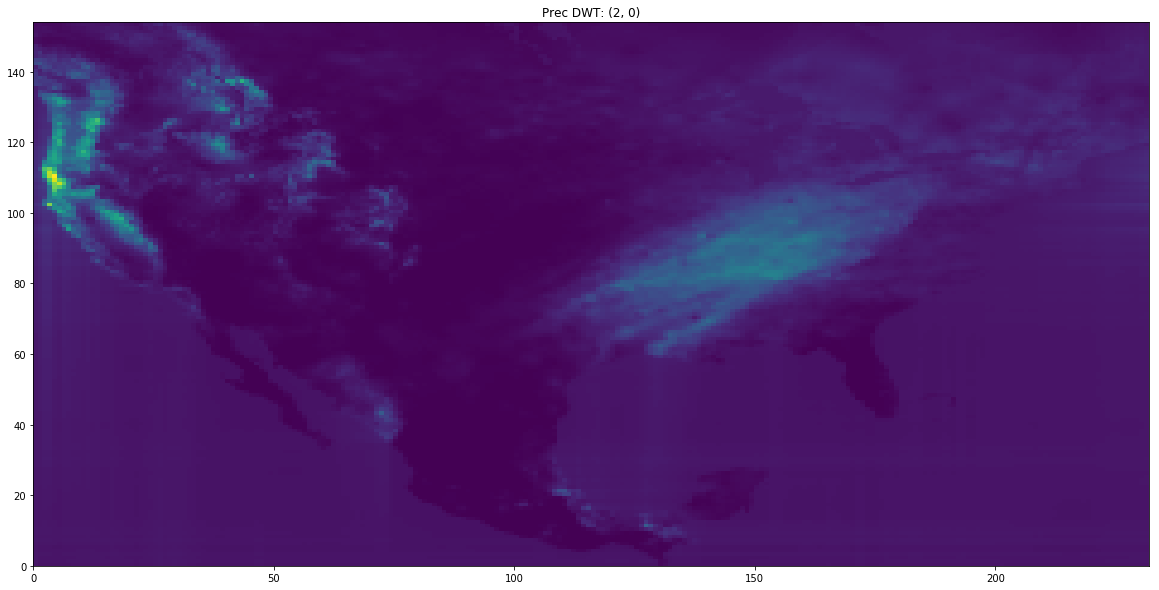

In [1017]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)

p0 = ax.pcolormesh(wp[0][0])
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title("Prec DWT: " + str((2,0)))

#ax.set_xticklabels(lon_space, minor=False)
#ax.set_yticklabels(lat_space, minor=False)

plt.show()

In [1041]:
for key in Prec_classes:
    Prec_classes[key] = Prec_classes[key] + nan_mask_slice

In [1042]:
for key in Tmax_classes:
    Tmax_classes[key] = Tmax_classes[key] + nan_mask_slice

In [1043]:
for key in Tmin_classes:
    Tmin_classes[key] = Tmin_classes[key] + nan_mask_slice

In [80]:
lat_space = np.linspace(start = np.min(ds.lat.data), stop = np.max(ds.lat.data), num = 7)
lat_space = np.round(lat_space, decimals = 1)
lon_space = np.linspace(start = np.min(ds.lon.data), stop = np.max(ds.lon.data), num = 7)
lon_space = np.round(lon_space, decimals = 1)

In [76]:
nan_mask_cube, nan_mask_slice, nan_mask_er_cube = build_masks(ds.Prec.data, iterations=4)

[Text(0,0,'14.7'),
 Text(0,0,'21.0'),
 Text(0,0,'27.4'),
 Text(0,0,'33.8'),
 Text(0,0,'40.2'),
 Text(0,0,'46.6'),
 Text(0,0,'53.0')]

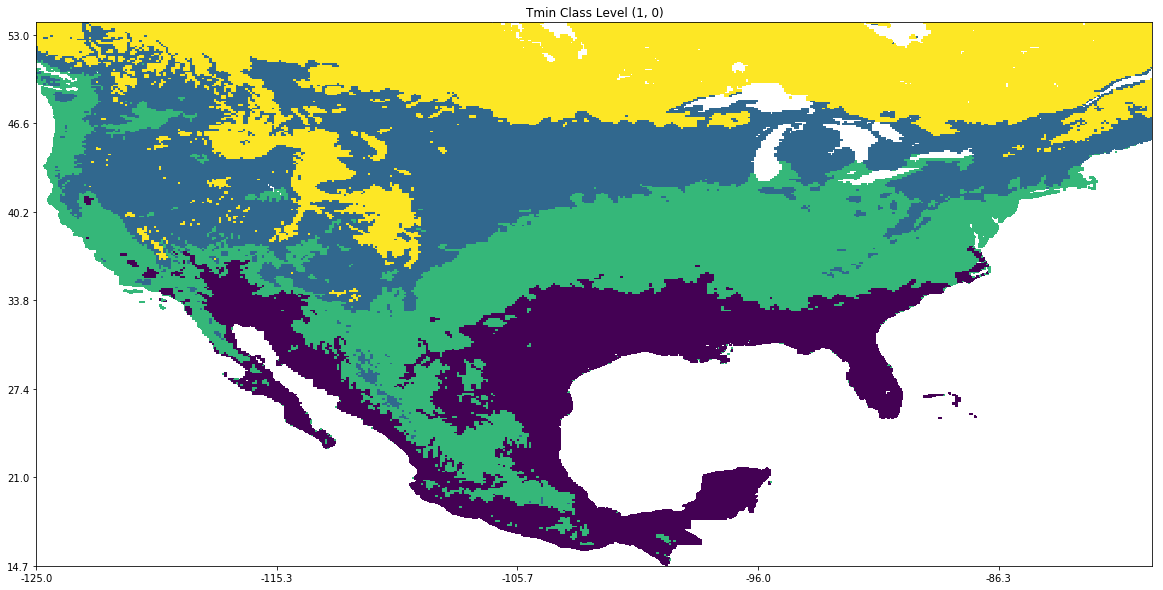

In [86]:
#######
#Means#
#######
#plt.figure(-1)
#f, ax = plt.subplots(figsize=(18, 6), ncols=3, nrows=1)
#Plot Prec
#p0= ax[0].pcolormesh(ds2.Prec.sum('time').data)
#plt.colorbar(p0, ax=ax[0], orientation='horizontal',
#             pad=0.07, fraction=0.05)
#ax[0].set_title('Prec Sum:')

#ax[0].set_xticklabels(lon_space, minor=False)
#ax[0].set_yticklabels(lat_space, minor=False)
#Plot Tmax
#p1= ax[1].pcolormesh(ds2.Tmax.max('time').data)
#plt.colorbar(p1, ax=ax[1], orientation='horizontal',
#             pad=0.07, fraction=0.05)
#ax[1].set_title('Tmax Max:')

#ax[1].set_xticklabels(lon_space, minor=False)
#ax[1].set_yticklabels(lat_space, minor=False)
#Plot Tmin
#p2= ax[2].pcolormesh(ds2.Tmin.min('time').data)
#plt.colorbar(p2, ax=ax[2], orientation='horizontal',
#             pad=0.07, fraction=0.05)
#ax[2].set_title('Tmin Min:')

#ax[2].set_xticklabels(lon_space, minor=False)
#ax[2].set_yticklabels(lat_space, minor=False)
#########
#Classes#
#########


f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)

#     #Plot Prec
# p0= ax.pcolormesh(Prec_classes[(1,0)] + nan_mask_slice)
#     #plt.colorbar(p0, ax=ax[0], orientation='horizontal',
#     #         pad=0.07, fraction=0.05)
# ax.set_title('Prec Class Level ' + str((1,0)))
# ax.set_xticklabels(lon_space, minor=False)
# ax.set_yticklabels(lat_space, minor=False)

#     #Plot Tmax
# p1= ax.pcolormesh(Tmax_classes[(1,0)]+nan_mask_slice)
#     #plt.colorbar(p1, ax=ax[1], orientation='horizontal',
#     #         pad=0.07, fraction=0.05)
# ax.set_title('Tmax Class Level ' + str((1,0)))
    
# ax.set_xticklabels(lon_space, minor=False)
# ax.set_yticklabels(lat_space, minor=False)


#     #Plot Tmin
p2= ax.pcolormesh(Tmin_classes[(1,0)]+nan_mask_slice)
    #plt.colorbar(p2, ax=ax[2], orientation='horizontal',
    #         pad=0.07, fraction=0.05)
ax.set_title('Tmin Class Level ' + str((1,0)))
    
ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

In [1035]:
np.save('Prec_class_sets_0_1_240', Prec_classes_all)

In [1036]:
np.save('Tmax_class_sets_0_1_240', Tmax_classes_all)

In [1037]:
np.save('Tmin_class_sets_0_1_240', Tmin_classes_all)

In [1038]:
np.save('label_sets_0_1_240', labels_all)

In [916]:
np.save('nan_mask_slice', nan_mask_slice)

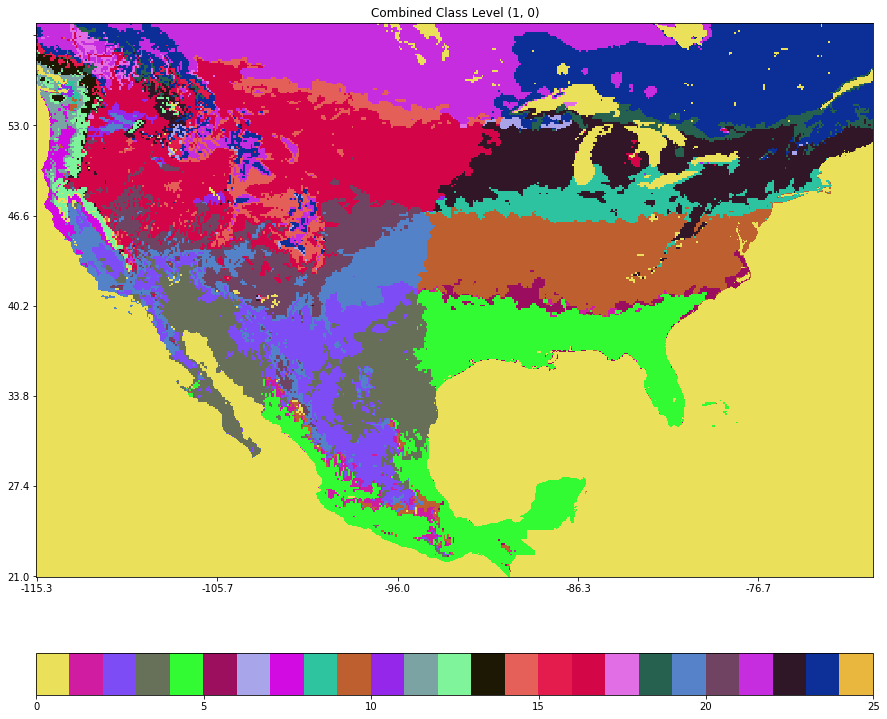

In [1039]:
colormap = np.random.uniform(low=0,high=1,size = (25,3))
cmap = color.ListedColormap(colormap)


f, ax = plt.subplots(figsize=(15, 20), ncols=1, nrows=1)
    #Plot Prec
p0 = plt.imshow(labels_all[0], cmap=cmap, origin = [0,0])
#p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax, orientation='horizontal',
             pad=0.07, fraction=0.05)
plt.clim(0, 25)
ax.set_title('Combined Class Level ' + str((1,0)))
    
ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()